In [1]:
import numpy as np

from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit.library import IntegerComparator
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel as GCI
from qiskit_finance.circuit.library.probability_distributions import NormalDistribution
import matplotlib.pyplot as plt

In [2]:
# set problem parameters
num_stock = 2 #保有する株の数
num_g = 2 #株価の変動を標準正規分布で表現する量子ビットの数
lgd = [100,120] #正規分布に対応する株価

mu = 0.5 #標準正規分布の平均
sigma = 0.1 #標準正規分布の分散

alpha = 0.5
epsilon = 0.1

# 各資産に割り当てられる標準正規分布の形


01 0.0244140625
10 0.7275390625
11 0.248046875


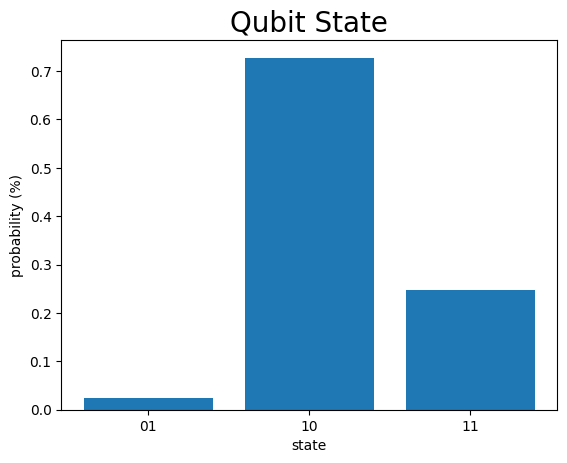

In [3]:

u = NormalDistribution(num_g, mu=mu, sigma=sigma)

u_measure = u.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(u_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

qubit_state = []

for i, prob in binary_probabilities.items():
    qubit_state.append([i,prob])
    print(i,prob)

# plot probabilities of each states
q_state = []
q_prob = []
for state in qubit_state:
    q_state.append(state[0])
    q_prob.append(state[1])

plt.bar(q_state,q_prob)
#plt.legend(fontsize=15)
plt.xlabel("state", size=10)
plt.ylabel("probability (%)", size=10)
plt.title("Qubit State", size=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

# 資産（株）ごとに標準正規分布を生成する

In [4]:
num_qubit = num_stock * num_g
qc = QuantumCircuit(num_qubit)

for i in range(num_stock):
    circuit = NormalDistribution(num_g, mu=mu, sigma=sigma)
    qc.compose(circuit,qubits=[2*i,2*i+1],inplace=True)

qc.draw()

┌───────┐
q_0: ┤0      ├
     │  P(X) │
q_1: ┤1      ├
     ├───────┤
q_2: ┤0      ├
     │  P(X) │
q_3: ┤1      ├
     └───────┘

In [5]:
qc_measure = qc.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(qc_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

0101 0.0009765625
1001 0.01953125
1101 0.0146484375
0110 0.0166015625
1010 0.52734375
0111 0.005859375
1111 0.0615234375
1110 0.1640625
1011 0.189453125


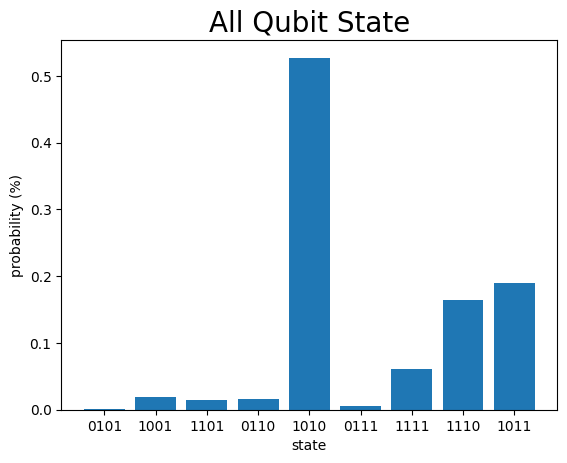

In [6]:
qubit_state = []

for i, prob in binary_probabilities.items():
    qubit_state.append([i,prob])
    print(i,prob)

# plot probabilities of each states
q_state = []
q_prob = []
for state in qubit_state:
    q_state.append(state[0])
    q_prob.append(state[1])

plt.bar(q_state,q_prob)
#plt.legend(fontsize=15)
plt.xlabel("state", size=10)
plt.ylabel("probability (%)", size=10)
plt.title("All Qubit State", size=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

# 全体の株価を加算する（工事中）

In [7]:
from qiskit.circuit.library import WeightedAdder

agg = WeightedAdder(num_stock * num_g, lgd * num_stock)

In [8]:
from qiskit.circuit.library import LinearAmplitudeFunction

# define linear objective function
breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum(lgd)
c_approx = 0.25

objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slope=slopes,
    offset=offsets,
    # max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2**agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

In [9]:
# define the registers for convenience and readability
qr_state = QuantumRegister(qc.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits+1, "carry")
qr_obj = QuantumRegister(1, "objective")

# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name="A")

# load the random variable
state_preparation.append(qc.to_gate(), qr_state)

# aggregate
state_preparation.append(agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])

# linear objective function
state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])

# uncompute aggregation
state_preparation.append(agg.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

# draw the circuit
state_preparation.draw()

┌──────────────┐┌─────────┐      ┌────────────┐
  state_0: ┤0             ├┤0        ├──────┤0           ├
           │              ││         │      │            │
  state_1: ┤1             ├┤1        ├──────┤1           ├
           │  circuit-176 ││         │      │            │
  state_2: ┤2             ├┤2        ├──────┤2           ├
           │              ││         │      │            │
  state_3: ┤3             ├┤3        ├──────┤3           ├
           └──────────────┘│         │┌────┐│            │
objective: ────────────────┤         ├┤9   ├┤            ├
                           │         ││    ││            │
    sum_0: ────────────────┤4        ├┤0   ├┤4           ├
                           │         ││    ││            │
    sum_1: ────────────────┤5        ├┤1   ├┤5           ├
                           │         ││    ││            │
    sum_2: ────────────────┤6        ├┤2   ├┤6           ├
                           │         ││    ││            │
    sum_3: ────────────────┤7        ├┤3   ├┤7           ├
                           │         ││  F ││            │
    sum_4: ────────────────┤8        ├┤4   ├┤8           ├
                           │         ││    ││            │
    sum_5: ────────────────┤9        ├┤5   ├┤9           ├
                           │         ││    ││            │
    sum_6: ────────────────┤10 adder ├┤6   ├┤10 adder_dg ├
                           │         ││    ││            │
    sum_7: ────────────────┤11       ├┤7   ├┤11          ├
                           │         ││    ││            │
    sum_8: ────────────────┤12       ├┤8   ├┤12          ├
                           │         │└────┘│            │
  carry_0: ────────────────┤13       ├──────┤13          ├
                           │         │      │            │
  carry_1: ────────────────┤14       ├──────┤14          ├
                           │         │      │            │
  carry_2: ────────────────┤15       ├──────┤15          ├
                           │         │      │            │
  carry_3: ────────────────┤16       ├──────┤16          ├
                           │         │      │            │
  carry_4: ────────────────┤17       ├──────┤17          ├
                           │         │      │            │
  carry_5: ────────────────┤18       ├──────┤18          ├
                           │         │      │            │
  carry_6: ────────────────┤19       ├──────┤19          ├
                           │         │      │            │
  carry_7: ────────────────┤20       ├──────┤20          ├
                           │         │      │            │
  carry_8: ────────────────┤21       ├──────┤21          ├
                           └─────────┘      └────────────┘

In [10]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [11]:
# evaluate the result
value = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1) :][0] == "1":
        value += prob

print("Exact Operator Value:  %.4f" % value)
print("Mapped Operator value: %.4f" % objective.post_processing(value))

Exact Operator Value:  0.7773
Mapped Operator value: 265.3750


In [12]:
# set target precision and confidence level

problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
)
result = ae.estimate(problem)

# print results
conf_int = np.array(result.confidence_interval_processed)
#print("Exact value:    \t%.4f" % expected_loss)
print("Estimated value:\t%.4f" % result.estimation_processed)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Estimated value:	297.0915
Confidence interval: 	[266.0350, 328.1480]
